In [17]:

# from google.colab import drive
# drive.mount('/content/drive/')


# Setup environment

In [18]:
# !pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

In [19]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [20]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64
TWEET = "tweet"
TARGET = "intention"
TOKENS = "tokens"

In [21]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
print(DEVICE)

cuda


# Data Preparation

## Load Data

In [23]:
sucidal_data = pd.read_csv("twitter-suicidal-data.csv")
SIZE = len(sucidal_data)

In [24]:
sucidal_data.head()

,tweet,intention
0,My life www.geeksforgeeks.org/category/python...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Data Preprocessing

In [25]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /home/hatef/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hatef/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hatef/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hatef/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
def convert_emoji_to_text(text):
  regrex_pattern = re.compile(pattern=r"[" u"\U0001F600-\U0001F64F"  # emoticons
                                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                    "]+", flags=re.UNICODE)
  return regrex_pattern.sub(r' ', text)
def remove_number(text):
  return ''.join([x for x in text if not x.isdigit()])
stopwords = nltk.corpus.stopwords.words("english")
def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word.lower() not in stopwords])
def remove_tag(text):
  words = text.split()
  filtered_words = [word for word in words if not word.startswith('@')]
  return ' '.join(filtered_words)
def remove_urls(text, replacement_text=" "):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  urls = url_pattern.findall(text)
  text = text.replace("https//", replacement_text)
  text = text.replace("http//", replacement_text)
  for url in urls:
    text = text.replace(url, replacement_text)
  return text
def to_lower(text: str):
  return text.lower()
def remove_whitespaces(text : str):
    return ' '.join(text.split())
def remove_punctuations(text):
    for punctuation in ["." "?", "!", "," , ";", ":" , "-" , "_", "{" ,"}" ,"(", ")" , "[", "]" , "‘", "...", "'",'"',  ]:
        text = text.replace(punctuation, '')
    return text
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    text = to_lower(text)
    text = remove_punctuations(text)
    text = remove_number(text)
    text = remove_urls(text)
    text = remove_tag(text)
    text = remove_whitespaces(text)
    text = convert_emoji_to_text(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    tokens = nltk.word_tokenize(text)
    return tokens


In [27]:
sucidal_data["tokens"] = sucidal_data[TWEET].apply(preprocess_data)

In [28]:
print (sucidal_data[TWEET].head())
print (sucidal_data[TOKENS].head())

0    My life  www.geeksforgeeks.org/category/python...
1    muttering i wanna die to myself daily for a fe...
2    work slave i really feel like my only purpose ...
3    i did something on the 2 of october i overdose...
4    i feel like no one cares i just want to die ma...
Name: tweet, dtype: object
0    [life, meaningless, want, end, life, badly, li...
1    [muttering, wan, na, die, daily, months, feel,...
2    [work, slave, really, feel, like, purpose, lif...
3    [something, october, overdosed, felt, alone, h...
4    [feel, like, one, cares, want, die, maybe, fee...
Name: tokens, dtype: object


#### why using lower case
I think for your particular use-case, it would be better to convert it to lowercase because ultimately, you will need to predict the words given a certain context. You probably won't be needing to predict sentence beginnings in your use-case. Also, if a noun is predicted you can capitalize it later. However consider the other way round. (Assuming your corpus is in English) Your model might treat a word which is in the beginning of a sentence with a capital letter different from the same word which appears later in the sentence but without any capital latter. This might lead to decline in the accuracy. Whereas I think, lowering the words would be a better trade off. I did a project on Question-answering system and converting the text to lowercase was a good trade off.
Since your corpus is in German, it would be better to retain the capitalization since it is an important aspect of German Language.

#### removing numbers
It depends on the problem statement for example year could be significant if you want to find the trend and year has many unique value but if it's constant then you can remove it.
To add to that if you are doing sentiment analysis then numeric variables don't make much sense.
in this case numbers are meaningless for example the time that someone experienced something isnt important than what actually happen there

#### tags
tags showing the overall concept of tweet for example ig someone post something with tag of depression it may be suicidal so tags are good feature and even help the model to make logical treatment between classes and features

In [29]:
import numpy as np

In [30]:
sucidal_data.head()

,tweet,intention,tokens
0,My life www.geeksforgeeks.org/category/python...,1,"[life, meaningless, want, end, life, badly, li..."
1,muttering i wanna die to myself daily for a fe...,1,"[muttering, wan, na, die, daily, months, feel,..."
2,work slave i really feel like my only purpose ...,1,"[work, slave, really, feel, like, purpose, lif..."
3,i did something on the 2 of october i overdose...,1,"[something, october, overdosed, felt, alone, h..."
4,i feel like no one cares i just want to die ma...,1,"[feel, like, one, cares, want, die, maybe, fee..."


# Word2Vec - Word Embedding

In [31]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [32]:
W2V_PATH = "WORD2VEC" # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [33]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

In [34]:
a = sucidal_data[TOKENS].apply(len)

In [35]:
sucidal_data[TOKENS]

0       [life, meaningless, want, end, life, badly, li...
1       [muttering, wan, na, die, daily, months, feel,...
2       [work, slave, really, feel, like, purpose, lif...
3       [something, october, overdosed, felt, alone, h...
4       [feel, like, one, cares, want, die, maybe, fee...
                              ...                        
9114    [ever, laid, bed, night, cried, good, enough, ...
9115    [fault, blame, pain, still, alone, inside, bro...
9116    [stop, asking, trust, still, coughing, water, ...
9117    [never, know, handle, sadness, crying, makes, ...
9118    [cancer, takes, life, blame, cancer, depressio...
Name: tokens, Length: 9119, dtype: object

In [36]:
print(len(a[a>700]))


8


In [37]:
sucidal_data[TOKENS] = sucidal_data[TOKENS][a<800]
sucidal_data.head()

,tweet,intention,tokens
0,My life www.geeksforgeeks.org/category/python...,1,"[life, meaningless, want, end, life, badly, li..."
1,muttering i wanna die to myself daily for a fe...,1,"[muttering, wan, na, die, daily, months, feel,..."
2,work slave i really feel like my only purpose ...,1,"[work, slave, really, feel, like, purpose, lif..."
3,i did something on the 2 of october i overdose...,1,"[something, october, overdosed, felt, alone, h..."
4,i feel like no one cares i just want to die ma...,1,"[feel, like, one, cares, want, die, maybe, fee..."


In [38]:
sucidal_data = sucidal_data.drop([1014  ,1169  ,1735  ,2637  ,2829  ,6710 ])

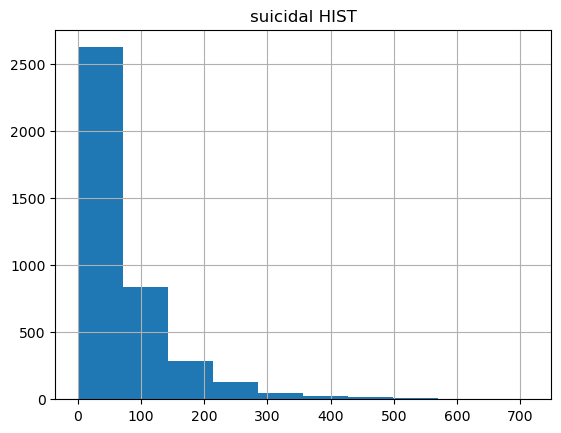

<Axes: title={'center': 'not-suicidal HIST'}>

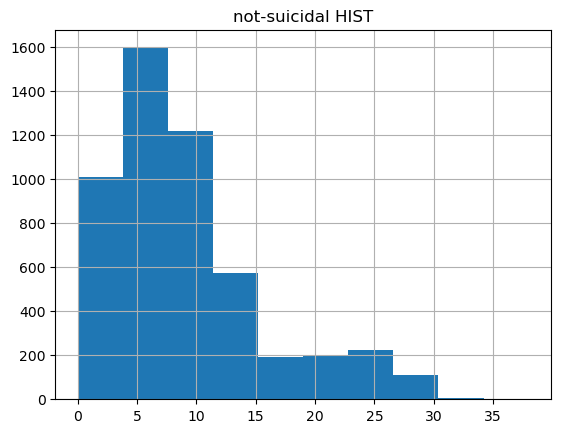

In [39]:
target= sucidal_data[TARGET]
suicidal_indexes = target == 1
not_suicidal_indexes = target == 0
sl  = sucidal_data[TOKENS][suicidal_indexes]
sl = sl.apply(len)
plt.title("suicidal HIST")
sl.hist()
plt.show()
nsl  = sucidal_data[TOKENS][not_suicidal_indexes]
nsl = nsl.apply(len)
plt.title("not-suicidal HIST")
nsl.hist()


SO SUICIDAL PERSONS ARE MORE moaning fart MORE

In [40]:
max(sucidal_data[TOKENS].apply(len))

713

# Dataset

In [41]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        # self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self , tokens: list) -> torch.tensor:
        result = []
        for x in tokens:
            if (x in w2v_model):
                result.append(w2v_model[x])
            else :
                result.append(w2v_model['0'])
        res = torch.tensor(np.array(result))
        return res


    def _pad(self, tokens: list):
        max_len = 713
        if(len(tokens)<max_len):
          diffrence = max_len - len(tokens)
          for i in range(diffrence):
            tokens.append('0')
        return tokens
    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

it is customary to use 3 to 1 for train and test so based on this rule of thumb :

In [42]:

train, test = train_test_split(sucidal_data, test_size=0.25, random_state=149)

In [43]:
print (train.head())

                                                  tweet  intention  \
8120  wowi want this shirt because supposedly medici...          0   
709   my girlfriend is suicidal i love her with all ...          1   
4053                         can t find my brown shoes           0   
1044  i didnt deserve to be a mom i dont deserve to ...          1   
11    i almost attempted suicide again when someone ...          1   

                                                 tokens  
8120  [wowi, want, shirt, supposedly, medicine, new,...  
709   [girlfriend, suicidal, love, heart, constantly...  
4053                               [find, brown, shoes]  
1044  [didnt, deserve, mom, dont, deserve, everythin...  
11    [almost, attempted, suicide, someone, blackmai...  


## Create Datasets

In [44]:
# TODO: create twitter dataset
# dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
train_dataset = Twitter(
    train , w2v_model, 713
)
valid_dataset = Twitter(
    test , w2v_model,713
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


Deleted 0-Len Samples: 28


/tmp/ipykernel_4223/3223112739.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


/tmp/ipykernel_4223/3223112739.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)
/tmp/ipykernel_4223/3223112739.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Deleted 0-Len Samples: 4
Train dataset length: 6806
Valid dataset length: 2275


/tmp/ipykernel_4223/3223112739.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [45]:
del w2v_model

In [46]:

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


Train dataset length: 6806
Valid dataset length: 2275


# Model and Train

The Adam optimizer achieves the highest accuracy in a reasonable amount of time. RMSprop achieves similar accuracy to Adam but with a much longer computation time. Surprisingly, the SGD algorithm required the least training time and produced the best results.
Adam tends to converge faster, while SGD often converges to more optimal solutions. SGD's high variance disadvantages gets rectified by Adam (as advantage for Adam).
##### SGD :
Precisely, stochastic gradient descent(SGD) refers to the specific case of vanilla GD when the batch size is 1. However, we will consider all mini-batch GD, SGD, and batch GD as SGD for convenience in this post.

SGD is the most basic form of GD. SGD subtracts the gradient multiplied by the learning rate from the weights. Despite its simplicity, SGD has strong theoretical foundations and is still used in training edge NNs.
##### Adam:
The basic idea behind Adam optimization is to adjust the learning rate adaptively for each parameter in the model based on the history of gradients calculated for that parameter. This helps the optimizer converge faster and more accurately than fixed learning rate methods like stochastic gradient descent (SGD).

## Utils

In [47]:

def model_eval(model, loader, loss_function, device: str = 'auto'):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    with torch.no_grad():  # Disable gradient computation during evaluation
        for inputs, labels in itr:
            # Move model's inputs to `device`
            inputs, labels = inputs.to(device), labels.to(device)

            # Use model's forward pass to generate outputs
            outputs = model(inputs)

            # Calculate model's loss
            loss = loss_function(outputs, labels)
            test_loss += (loss.item()*64)/len(valid_dataset)

            # Calculate/update model's accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct = (predicted == labels).sum().item()
            test_acc += correct / len(valid_dataset)

            itr.set_description('(Eval)')
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(test_acc, 5),
            )

    return test_loss, test_acc


In [48]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device,
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # TODO: create dataloaders from datasets

    train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size= batch_size, shuffle=True)

    model.to(device)

    itr = tqdm(train_loader, total=len(train_loader), leave=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        for idx, (inputs, labels) in enumerate(train_loader, start=1):
            # Move model's inputs to `device`
            inputs, labels = inputs.to(device), labels.to(device)

            # Use model's forward pass to generate outputs
            outputs = model(inputs)

            # Process model's predictions and calculate/update accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct = (predicted == labels).sum().item()
            epoch_acc += correct / len(labels)

            # Calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # Clear optimizer's state and zero previous gradients
            optimizer.zero_grad()

            # Backward pass to compute gradients
            loss.backward()

            # Update model parameters
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc / idx, 5),
            )



        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )
        train_accs.append(round(epoch_acc / idx, 5))
        train_losses.append(round(loss.item(), 5))
        valid_accs.append(valid_acc)
        valid_losses.append(valid_loss)
        # Update statistics regarding model's loss and accuracy in training or validation phases
        print(f"Validation Loss: {valid_loss:.5f} | Validation Accuracy: {valid_acc:.5f}",end= "\r")

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [49]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [50]:

def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Disable gradient computation during evaluation
        for inputs, labels in itr:
            # Move model's inputs to `device`
            inputs, labels = inputs.to(device), labels.to(device)

            # Use model's forward pass to generate outputs
            outputs = model(inputs)

            # Get predicted labels
            _, predicted = torch.max(outputs, dim=1)

            # Append true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate confusion matrix
    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f")
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    # Calculate additional metrics
    recall = metrics.recall_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
    f1 = metrics.f1_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
    precision = metrics.precision_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

#### KERNEL SIZE
Smaller kernel sizes capture more local information, while larger kernel sizes capture more global information. It's essential to strike a balance between capturing local details and considering broader context

#### REDUCTION
the output of Convolution is some features and we need a classifier at the end the feed forward is the classifier

In [51]:

class CNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CNN, self).__init__()
        # Define network's layers
        self.conv1_3 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.conv1_5 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=5, padding=2)
        self.conv1_7 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=7, padding=3)
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 128*300, 128)  # Assuming that '3' is the flattened dimension after convolutions
        self.fc2 = nn.Linear(128, output_channels)

    def forward(self, x):
        # Implement forward pass
        x1_3 = torch.relu(self.conv1_3(x))
        x1_5 = torch.relu(self.conv1_5(x))
        x1_7 = torch.relu(self.conv1_7(x))

        x2_3 = torch.relu(self.conv2_3(x1_3))
        x2_5 = torch.relu(self.conv2_5(x1_5))
        x2_7 = torch.relu(self.conv2_7(x1_7))
        # Assuming concatenation along dimension resulting in '3 * 128' features before flattening
        x_concatenated = torch.cat((x2_3, x2_5, x2_7), dim = 1)
        x_flatten = self.flatten(x_concatenated)
        # Concatenating along feature dimension assuming it results in '3 * 128' features.
        # This may need adjustment based on actual dimensions after convolution.
        x_fc1 = torch.relu(self.fc1(x_flatten))
        output = self.fc2(x_fc1)

        return output


## Training

In [52]:
# TODO: instantiate your model here
input_channels = 713
output_channels = 2
model = CNN(input_channels, output_channels)


In [66]:
cnn_model_train_history = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters()),
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)


(Training) Epoch [1/15]:   0%|          | 0/107 [00:00<?, ?it/s, accuracy=0.5, loss=0.694]

(Training) Epoch [2/15]:   0%|          | 0/107 [00:07<?, ?it/s, accuracy=0.854, loss=0.357]

(Training) Epoch [3/15]:   0%|          | 0/107 [00:14<?, ?it/s, accuracy=0.766, loss=0.595]

(Training) Epoch [4/15]:   0%|          | 0/107 [00:22<?, ?it/s, accuracy=0.88, loss=0.313] 

(Training) Epoch [5/15]:   0%|          | 0/107 [00:29<?, ?it/s, accuracy=0.865, loss=0.143]

(Training) Epoch [6/15]:   0%|          | 0/107 [00:36<?, ?it/s, accuracy=0.875, loss=0.24]  

(Training) Epoch [7/15]:   0%|          | 0/107 [00:43<?, ?it/s, accuracy=0.901, loss=0.147]

(Training) Epoch [8/15]:   0%|          | 0/107 [00:51<?, ?it/s, accuracy=0.906, loss=0.414] 

(Training) Epoch [9/15]:   0%|          | 0/107 [00:58<?, ?it/s, accuracy=0.901, loss=0.438] 

(Training) Epoch [10/15]:   0%|          | 0/107 [01:05<?, ?it/s, accuracy=0.927, loss=0.202]

(Training) Epoch [11/15]:   0%|          | 0/107 [01:13<?, ?it/s, accuracy=0.927, loss=0.245] 

(Training) Epoch [12/15]:   0%|          | 0/107 [01:20<?, ?it/s, accuracy=0.896, loss=0.324] 

(Training) Epoch [13/15]:   0%|          | 0/107 [01:28<?, ?it/s, accuracy=0.906, loss=0.194] 

(Training) Epoch [14/15]:   0%|          | 0/107 [01:35<?, ?it/s, accuracy=0.948, loss=0.154] 

(Training) Epoch [15/15]:   0%|          | 0/107 [01:43<?, ?it/s, accuracy=0.901, loss=0.201] 

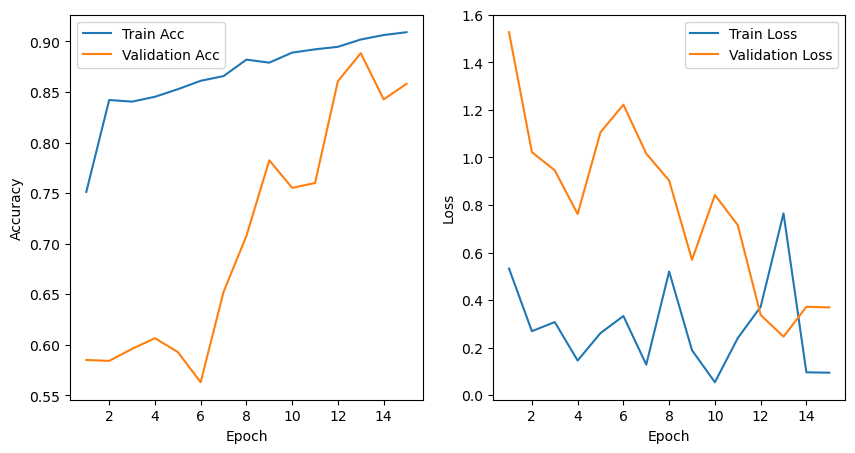

In [65]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

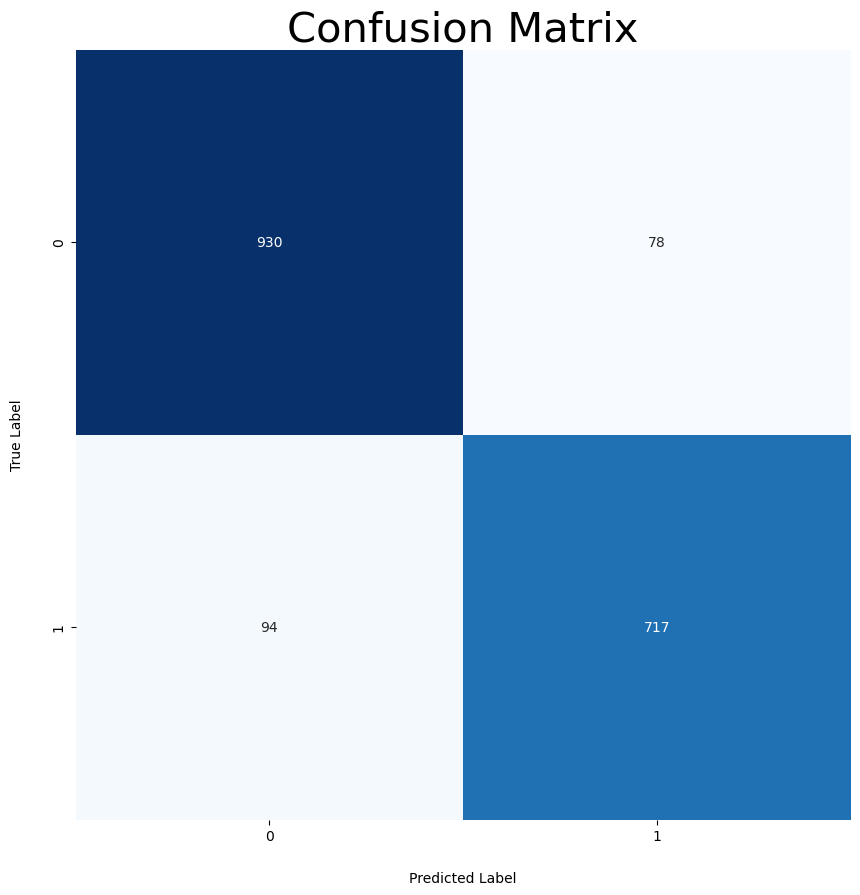

In [ ]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [ ]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.903
F1:        0.904
Precision: 0.905
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1008
           1       0.90      0.88      0.89       811

    accuracy                           0.91      1819
   macro avg       0.91      0.90      0.90      1819
weighted avg       0.91      0.91      0.91      1819



### third PART


####   increasing CONTEXT WINDOW LEN
pros : it could find long term dependencies<br>
cons : make model very complicated and its parameters are huge and its takes long to run and short term features are not founded



In [ ]:

class BKCNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(BKCNN, self).__init__()
        # Define network's layers
        self.conv1_3 = nn.Conv1d(in_channels=input_channels, out_channels=3, kernel_size=193, padding=96)
        self.conv1_5 = nn.Conv1d(in_channels=input_channels, out_channels=3, kernel_size=193, padding=96)
        self.conv1_7 = nn.Conv1d(in_channels=input_channels, out_channels=3, kernel_size=193, padding=96)
        self.conv2_3 = nn.Conv1d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=3, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=3, out_channels=128, kernel_size=7, padding=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 128*300, 128)  # Assuming that '3' is the flattened dimension after convolutions
        self.fc2 = nn.Linear(128, output_channels)

    def forward(self, x):
        # Implement forward pass
        x1_3 = torch.relu(self.conv1_3(x))
        x1_5 = torch.relu(self.conv1_5(x))
        x1_7 = torch.relu(self.conv1_7(x))

        x2_3 = torch.relu(self.conv2_3(x1_3))
        x2_5 = torch.relu(self.conv2_5(x1_5))
        x2_7 = torch.relu(self.conv2_7(x1_7))
        # Assuming concatenation along dimension resulting in '3 * 128' features before flattening
        x_concatenated = torch.cat((x2_3, x2_5, x2_7), dim = 1)
        x_flatten = self.flatten(x_concatenated)
        # Concatenating along feature dimension assuming it results in '3 * 128' features.
        # This may need adjustment based on actual dimensions after convolution.
        x_fc1 = torch.relu(self.fc1(x_flatten))
        output = self.fc2(x_fc1)

        return output


In [ ]:
seconde_model = BKCNN(input_channels , output_channels)


In [ ]:
cnn_model_train_history = train_model(
    model=seconde_model,
    batch_size=BATCH_SIZE,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(seconde_model.parameters()),
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)






  0%|          | 0/107 [00:00<?, ?it/s]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:00<?, ?it/s]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:00<?, ?it/s, accuracy=0.547, loss=0.691]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:00<?, ?it/s, accuracy=0.547, loss=0.691]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:01<?, ?it/s, accuracy=0.555, loss=0.69] 



(Training) Epoch [1/15]:   0%|          | 0/107 [00:01<?, ?it/s, accuracy=0.555, loss=0.69]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:01<?, ?it/s, accuracy=0.542, loss=0.693]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:01<?, ?it/s, accuracy=0.542, loss=0.693]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:01<?, ?it/s, accuracy=0.539, loss=0.692]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:01<?, ?it/s, accuracy=0.539, loss=0.692]



(Training) Epoch [1/15]:   0%|          | 0/107 [00:02<?, ?it/s, accuracy=0.556, loss=0.685]



(Training) Epoch [1/15

Validation Loss: 0.69869 | Validation Accuracy: 0.55780






(Training) Epoch [2/15]:   0%|          | 0/107 [00:31<?, ?it/s, accuracy=0.547, loss=0.691]



(Training) Epoch [2/15]:   0%|          | 0/107 [00:31<?, ?it/s, accuracy=0.547, loss=0.691]



(Training) Epoch [2/15]:   0%|          | 0/107 [00:32<?, ?it/s, accuracy=0.57, loss=0.687] 



(Training) Epoch [2/15]:   0%|          | 0/107 [00:32<?, ?it/s, accuracy=0.57, loss=0.687]



(Training) Epoch [2/15]:   0%|          | 0/107 [00:32<?, ?it/s, accuracy=0.604, loss=0.682]



(Training) Epoch [2/15]:   0%|          | 0/107 [00:32<?, ?it/s, accuracy=0.604, loss=0.682]



(Training) Epoch [2/15]:   0%|          | 0/107 [00:32<?, ?it/s, accuracy=0.594, loss=0.69] 



(Training) Epoch [2/15]:   0%|          | 0/107 [00:32<?, ?it/s, accuracy=0.594, loss=0.69]



(Training) Epoch [2/15]:   0%|          | 0/107 [00:32<?, ?it/s, accuracy=0.591, loss=0.688]



(Training) Epoch [2/15]:   0%|          | 0/107 [00:32<?, ?it/s, accuracy=0.591, loss=0.688]



(Training) Epoch [2/15]:   0%|        

Validation Loss: 0.69869 | Validation Accuracy: 0.55780






(Training) Epoch [3/15]:   0%|          | 0/107 [01:02<?, ?it/s, accuracy=0.516, loss=0.693]



(Training) Epoch [3/15]:   0%|          | 0/107 [01:02<?, ?it/s, accuracy=0.516, loss=0.693]



(Training) Epoch [3/15]:   0%|          | 0/107 [01:02<?, ?it/s, accuracy=0.531, loss=0.691]



(Training) Epoch [3/15]:   0%|          | 0/107 [01:02<?, ?it/s, accuracy=0.531, loss=0.691]



(Training) Epoch [3/15]:   0%|          | 0/107 [01:02<?, ?it/s, accuracy=0.589, loss=0.68] 



(Training) Epoch [3/15]:   0%|          | 0/107 [01:02<?, ?it/s, accuracy=0.589, loss=0.68]



(Training) Epoch [3/15]:   0%|          | 0/107 [01:02<?, ?it/s, accuracy=0.582, loss=0.689]



(Training) Epoch [3/15]:   0%|          | 0/107 [01:03<?, ?it/s, accuracy=0.582, loss=0.689]



(Training) Epoch [3/15]:   0%|          | 0/107 [01:03<?, ?it/s, accuracy=0.566, loss=0.694]



(Training) Epoch [3/15]:   0%|          | 0/107 [01:03<?, ?it/s, accuracy=0.566, loss=0.694]



(Training) Epoch [3/15]:   0%|       

Validation Loss: 0.69866 | Validation Accuracy: 0.55780






(Training) Epoch [4/15]:   0%|          | 0/107 [01:32<?, ?it/s, accuracy=0.562, loss=0.69]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:32<?, ?it/s, accuracy=0.562, loss=0.69]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:32<?, ?it/s, accuracy=0.617, loss=0.682]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:33<?, ?it/s, accuracy=0.617, loss=0.682]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:33<?, ?it/s, accuracy=0.578, loss=0.694]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:33<?, ?it/s, accuracy=0.578, loss=0.694]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:33<?, ?it/s, accuracy=0.547, loss=0.697]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:33<?, ?it/s, accuracy=0.547, loss=0.697]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:33<?, ?it/s, accuracy=0.566, loss=0.684]



(Training) Epoch [4/15]:   0%|          | 0/107 [01:33<?, ?it/s, accuracy=0.566, loss=0.684]



(Training) Epoch [4/15]:   0%|        

Validation Loss: 0.69866 | Validation Accuracy: 0.55780






(Training) Epoch [5/15]:   0%|          | 0/107 [02:04<?, ?it/s, accuracy=0.562, loss=0.689]



(Training) Epoch [5/15]:   0%|          | 0/107 [02:04<?, ?it/s, accuracy=0.562, loss=0.689]



(Training) Epoch [5/15]:   0%|          | 0/107 [02:04<?, ?it/s, accuracy=0.586, loss=0.686]



(Training) Epoch [5/15]:   0%|          | 0/107 [02:05<?, ?it/s, accuracy=0.586, loss=0.686]



(Training) Epoch [5/15]:   0%|          | 0/107 [02:05<?, ?it/s, accuracy=0.589, loss=0.688]



(Training) Epoch [5/15]:   0%|          | 0/107 [02:05<?, ?it/s, accuracy=0.589, loss=0.688]



(Training) Epoch [5/15]:   0%|          | 0/107 [02:05<?, ?it/s, accuracy=0.59, loss=0.687] 



(Training) Epoch [5/15]:   0%|          | 0/107 [02:05<?, ?it/s, accuracy=0.59, loss=0.687]



(Training) Epoch [5/15]:   0%|          | 0/107 [02:05<?, ?it/s, accuracy=0.572, loss=0.694]



(Training) Epoch [5/15]:   0%|          | 0/107 [02:05<?, ?it/s, accuracy=0.572, loss=0.694]



(Training) Epoch [5/15]:   0%|       

Validation Loss: 0.69859 | Validation Accuracy: 0.55780






(Training) Epoch [6/15]:   0%|          | 0/107 [02:35<?, ?it/s, accuracy=0.453, loss=0.697]



(Training) Epoch [6/15]:   0%|          | 0/107 [02:35<?, ?it/s, accuracy=0.453, loss=0.697]



(Training) Epoch [6/15]:   0%|          | 0/107 [02:36<?, ?it/s, accuracy=0.547, loss=0.684]



(Training) Epoch [6/15]:   0%|          | 0/107 [02:36<?, ?it/s, accuracy=0.547, loss=0.684]



(Training) Epoch [6/15]:   0%|          | 0/107 [02:36<?, ?it/s, accuracy=0.557, loss=0.688]



(Training) Epoch [6/15]:   0%|          | 0/107 [02:36<?, ?it/s, accuracy=0.557, loss=0.688]



(Training) Epoch [6/15]:   0%|          | 0/107 [02:36<?, ?it/s, accuracy=0.543, loss=0.694]



(Training) Epoch [6/15]:   0%|          | 0/107 [02:36<?, ?it/s, accuracy=0.543, loss=0.694]



(Training) Epoch [6/15]:   0%|          | 0/107 [02:36<?, ?it/s, accuracy=0.55, loss=0.689] 



(Training) Epoch [6/15]:   0%|          | 0/107 [02:36<?, ?it/s, accuracy=0.55, loss=0.689]



(Training) Epoch [6/15]:   0%|       

Validation Loss: 0.69864 | Validation Accuracy: 0.55780






(Training) Epoch [7/15]:   0%|          | 0/107 [03:07<?, ?it/s, accuracy=0.531, loss=0.692]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:07<?, ?it/s, accuracy=0.531, loss=0.692]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:07<?, ?it/s, accuracy=0.531, loss=0.691]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:07<?, ?it/s, accuracy=0.531, loss=0.691]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:07<?, ?it/s, accuracy=0.536, loss=0.691]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:07<?, ?it/s, accuracy=0.536, loss=0.691]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:07<?, ?it/s, accuracy=0.551, loss=0.687]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:08<?, ?it/s, accuracy=0.551, loss=0.687]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:08<?, ?it/s, accuracy=0.556, loss=0.688]



(Training) Epoch [7/15]:   0%|          | 0/107 [03:08<?, ?it/s, accuracy=0.556, loss=0.688]



(Training) Epoch [7/15]:   0%|      

Validation Loss: 0.69859 | Validation Accuracy: 0.55780






(Training) Epoch [8/15]:   0%|          | 0/107 [03:38<?, ?it/s, accuracy=0.578, loss=0.689]



(Training) Epoch [8/15]:   0%|          | 0/107 [03:39<?, ?it/s, accuracy=0.578, loss=0.689]



(Training) Epoch [8/15]:   0%|          | 0/107 [03:39<?, ?it/s, accuracy=0.5, loss=0.699]  



(Training) Epoch [8/15]:   0%|          | 0/107 [03:39<?, ?it/s, accuracy=0.5, loss=0.699]



(Training) Epoch [8/15]:   0%|          | 0/107 [03:39<?, ?it/s, accuracy=0.479, loss=0.698]



(Training) Epoch [8/15]:   0%|          | 0/107 [03:39<?, ?it/s, accuracy=0.479, loss=0.698]



(Training) Epoch [8/15]:   0%|          | 0/107 [03:39<?, ?it/s, accuracy=0.504, loss=0.689]



(Training) Epoch [8/15]:   0%|          | 0/107 [03:39<?, ?it/s, accuracy=0.504, loss=0.689]



(Training) Epoch [8/15]:   0%|          | 0/107 [03:40<?, ?it/s, accuracy=0.537, loss=0.682]



(Training) Epoch [8/15]:   0%|          | 0/107 [03:40<?, ?it/s, accuracy=0.537, loss=0.682]



(Training) Epoch [8/15]:   0%|        

Validation Loss: 0.69871 | Validation Accuracy: 0.55780






(Training) Epoch [9/15]:   0%|          | 0/107 [04:10<?, ?it/s, accuracy=0.625, loss=0.685]



(Training) Epoch [9/15]:   0%|          | 0/107 [04:10<?, ?it/s, accuracy=0.625, loss=0.685]



(Training) Epoch [9/15]:   0%|          | 0/107 [04:11<?, ?it/s, accuracy=0.602, loss=0.688]



(Training) Epoch [9/15]:   0%|          | 0/107 [04:11<?, ?it/s, accuracy=0.602, loss=0.688]



(Training) Epoch [9/15]:   0%|          | 0/107 [04:11<?, ?it/s, accuracy=0.557, loss=0.696]



(Training) Epoch [9/15]:   0%|          | 0/107 [04:11<?, ?it/s, accuracy=0.557, loss=0.696]



(Training) Epoch [9/15]:   0%|          | 0/107 [04:11<?, ?it/s, accuracy=0.555, loss=0.69] 



(Training) Epoch [9/15]:   0%|          | 0/107 [04:11<?, ?it/s, accuracy=0.555, loss=0.69]



(Training) Epoch [9/15]:   0%|          | 0/107 [04:11<?, ?it/s, accuracy=0.562, loss=0.688]



(Training) Epoch [9/15]:   0%|          | 0/107 [04:11<?, ?it/s, accuracy=0.562, loss=0.688]



(Training) Epoch [9/15]:   0%|       

Validation Loss: 0.69852 | Validation Accuracy: 0.55780






(Training) Epoch [10/15]:   0%|          | 0/107 [04:42<?, ?it/s, accuracy=0.609, loss=0.686]



(Training) Epoch [10/15]:   0%|          | 0/107 [04:42<?, ?it/s, accuracy=0.609, loss=0.686]



(Training) Epoch [10/15]:   0%|          | 0/107 [04:42<?, ?it/s, accuracy=0.555, loss=0.694]



(Training) Epoch [10/15]:   0%|          | 0/107 [04:43<?, ?it/s, accuracy=0.555, loss=0.694]



(Training) Epoch [10/15]:   0%|          | 0/107 [04:43<?, ?it/s, accuracy=0.573, loss=0.686]



(Training) Epoch [10/15]:   0%|          | 0/107 [04:43<?, ?it/s, accuracy=0.573, loss=0.686]



(Training) Epoch [10/15]:   0%|          | 0/107 [04:43<?, ?it/s, accuracy=0.531, loss=0.7]  



(Training) Epoch [10/15]:   0%|          | 0/107 [04:43<?, ?it/s, accuracy=0.531, loss=0.7]



(Training) Epoch [10/15]:   0%|          | 0/107 [04:43<?, ?it/s, accuracy=0.528, loss=0.693]



(Training) Epoch [10/15]:   0%|          | 0/107 [04:43<?, ?it/s, accuracy=0.528, loss=0.693]



(Training) Epoch [10/15]:   

Validation Loss: 0.69856 | Validation Accuracy: 0.55780






(Training) Epoch [11/15]:   0%|          | 0/107 [05:14<?, ?it/s, accuracy=0.609, loss=0.686]



(Training) Epoch [11/15]:   0%|          | 0/107 [05:14<?, ?it/s, accuracy=0.609, loss=0.686]



(Training) Epoch [11/15]:   0%|          | 0/107 [05:14<?, ?it/s, accuracy=0.594, loss=0.688]



(Training) Epoch [11/15]:   0%|          | 0/107 [05:14<?, ?it/s, accuracy=0.594, loss=0.688]



(Training) Epoch [11/15]:   0%|          | 0/107 [05:14<?, ?it/s, accuracy=0.583, loss=0.69] 



(Training) Epoch [11/15]:   0%|          | 0/107 [05:14<?, ?it/s, accuracy=0.583, loss=0.69]



(Training) Epoch [11/15]:   0%|          | 0/107 [05:15<?, ?it/s, accuracy=0.594, loss=0.685]



(Training) Epoch [11/15]:   0%|          | 0/107 [05:15<?, ?it/s, accuracy=0.594, loss=0.685]



(Training) Epoch [11/15]:   0%|          | 0/107 [05:15<?, ?it/s, accuracy=0.597, loss=0.686]



(Training) Epoch [11/15]:   0%|          | 0/107 [05:15<?, ?it/s, accuracy=0.597, loss=0.686]



(Training) Epoch [11/15]:  

Validation Loss: 0.69869 | Validation Accuracy: 0.55780






(Training) Epoch [12/15]:   0%|          | 0/107 [05:46<?, ?it/s, accuracy=0.438, loss=0.698]



(Training) Epoch [12/15]:   0%|          | 0/107 [05:46<?, ?it/s, accuracy=0.438, loss=0.698]



(Training) Epoch [12/15]:   0%|          | 0/107 [05:46<?, ?it/s, accuracy=0.531, loss=0.686]



(Training) Epoch [12/15]:   0%|          | 0/107 [05:46<?, ?it/s, accuracy=0.531, loss=0.686]



(Training) Epoch [12/15]:   0%|          | 0/107 [05:46<?, ?it/s, accuracy=0.526, loss=0.693]



(Training) Epoch [12/15]:   0%|          | 0/107 [05:46<?, ?it/s, accuracy=0.526, loss=0.693]



(Training) Epoch [12/15]:   0%|          | 0/107 [05:46<?, ?it/s, accuracy=0.535, loss=0.69] 



(Training) Epoch [12/15]:   0%|          | 0/107 [05:47<?, ?it/s, accuracy=0.535, loss=0.69]



(Training) Epoch [12/15]:   0%|          | 0/107 [05:47<?, ?it/s, accuracy=0.547, loss=0.687]



(Training) Epoch [12/15]:   0%|          | 0/107 [05:47<?, ?it/s, accuracy=0.547, loss=0.687]



(Training) Epoch [12/15]:  

Validation Loss: 0.69871 | Validation Accuracy: 0.55780






(Training) Epoch [13/15]:   0%|          | 0/107 [06:17<?, ?it/s, accuracy=0.594, loss=0.687]



(Training) Epoch [13/15]:   0%|          | 0/107 [06:18<?, ?it/s, accuracy=0.594, loss=0.687]



(Training) Epoch [13/15]:   0%|          | 0/107 [06:18<?, ?it/s, accuracy=0.547, loss=0.694]



(Training) Epoch [13/15]:   0%|          | 0/107 [06:18<?, ?it/s, accuracy=0.547, loss=0.694]



(Training) Epoch [13/15]:   0%|          | 0/107 [06:18<?, ?it/s, accuracy=0.516, loss=0.697]



(Training) Epoch [13/15]:   0%|          | 0/107 [06:18<?, ?it/s, accuracy=0.516, loss=0.697]



(Training) Epoch [13/15]:   0%|          | 0/107 [06:18<?, ?it/s, accuracy=0.527, loss=0.69] 



(Training) Epoch [13/15]:   0%|          | 0/107 [06:18<?, ?it/s, accuracy=0.527, loss=0.69]



(Training) Epoch [13/15]:   0%|          | 0/107 [06:19<?, ?it/s, accuracy=0.553, loss=0.683]



(Training) Epoch [13/15]:   0%|          | 0/107 [06:19<?, ?it/s, accuracy=0.553, loss=0.683]



(Training) Epoch [13/15]:  

Validation Loss: 0.69876 | Validation Accuracy: 0.55780






(Training) Epoch [14/15]:   0%|          | 0/107 [06:50<?, ?it/s, accuracy=0.5, loss=0.694]  



(Training) Epoch [14/15]:   0%|          | 0/107 [06:50<?, ?it/s, accuracy=0.5, loss=0.694]



(Training) Epoch [14/15]:   0%|          | 0/107 [06:50<?, ?it/s, accuracy=0.531, loss=0.689]



(Training) Epoch [14/15]:   0%|          | 0/107 [06:50<?, ?it/s, accuracy=0.531, loss=0.689]



(Training) Epoch [14/15]:   0%|          | 0/107 [06:50<?, ?it/s, accuracy=0.547, loss=0.689]



(Training) Epoch [14/15]:   0%|          | 0/107 [06:50<?, ?it/s, accuracy=0.547, loss=0.689]



(Training) Epoch [14/15]:   0%|          | 0/107 [06:51<?, ?it/s, accuracy=0.527, loss=0.696]



(Training) Epoch [14/15]:   0%|          | 0/107 [06:51<?, ?it/s, accuracy=0.527, loss=0.696]



(Training) Epoch [14/15]:   0%|          | 0/107 [06:51<?, ?it/s, accuracy=0.537, loss=0.688]



(Training) Epoch [14/15]:   0%|          | 0/107 [06:51<?, ?it/s, accuracy=0.537, loss=0.688]



(Training) Epoch [14/15]:   

Validation Loss: 0.69854 | Validation Accuracy: 0.55780






(Training) Epoch [15/15]:   0%|          | 0/107 [07:22<?, ?it/s, accuracy=0.641, loss=0.684]



(Training) Epoch [15/15]:   0%|          | 0/107 [07:23<?, ?it/s, accuracy=0.641, loss=0.684]



(Training) Epoch [15/15]:   0%|          | 0/107 [07:23<?, ?it/s, accuracy=0.594, loss=0.69] 



(Training) Epoch [15/15]:   0%|          | 0/107 [07:23<?, ?it/s, accuracy=0.594, loss=0.69]



(Training) Epoch [15/15]:   0%|          | 0/107 [07:23<?, ?it/s, accuracy=0.562, loss=0.694]



(Training) Epoch [15/15]:   0%|          | 0/107 [07:23<?, ?it/s, accuracy=0.562, loss=0.694]



(Training) Epoch [15/15]:   0%|          | 0/107 [07:23<?, ?it/s, accuracy=0.578, loss=0.685]



(Training) Epoch [15/15]:   0%|          | 0/107 [07:23<?, ?it/s, accuracy=0.578, loss=0.685]



(Training) Epoch [15/15]:   0%|          | 0/107 [07:24<?, ?it/s, accuracy=0.581, loss=0.687]



(Training) Epoch [15/15]:   0%|          | 0/107 [07:24<?, ?it/s, accuracy=0.581, loss=0.687]



(Training) Epoch [15/15]:  

Validation Loss: 0.69869 | Validation Accuracy: 0.55780


no its shitty as we thught the kernel size is very big and it end up to be bad and ignore the short term details (please read in indaian accent)

In [ ]:
del seconde_model

NameError: name 'seconde_model' is not defined

In [78]:

class BCNN(nn.Module):
    def __init__(self, input_channels, output_channels, dropout_rate=0.5):
        super(BCNN, self).__init__()
        # Define network's layers
        self.conv1_3 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.conv1_5 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=5, padding=2)
        self.conv1_7 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=7, padding=3)
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv2_7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 128 * 300, 128)  # Assuming that '3' is the flattened dimension after convolutions
        self.fc2 = nn.Linear(128, output_channels)
        self.dropout = nn.Dropout(p=dropout_rate)  # Add dropout layer
        #self.batch_norm1 = nn.BatchNorm1d(64)  # Add batch normalization layers
        #self.batch_norm2 = nn.BatchNorm1d(128)

    def forward(self, x):
        # Implement forward pass
        x1_3 = torch.relu(self.conv1_3(x))  # Apply batch normalization
        x1_5 = torch.relu(self.conv1_5(x))
        x1_7 = torch.relu(self.conv1_7(x))

        x2_3 = torch.relu(self.conv2_3(x1_3))
        x2_5 = torch.relu(self.conv2_5(x1_5))
        x2_7 = torch.relu((self.conv2_7(x1_7)))

        x_concatenated = torch.cat((x2_3, x2_5, x2_7), dim=1)
        x_flatten = self.flatten(x_concatenated)
        x_fc1 = torch.relu(self.fc1(x_flatten))
        x_fc1_dropout = self.dropout(x_fc1)  # Add dropout layer
        output = self.fc2(x_fc1_dropout)

        return output


In [79]:
third = BCNN(input_channels , output_channels,0.1)


In [81]:
cnn_model_train_history = train_model(
    model=third,
    batch_size=BATCH_SIZE,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(third.parameters()),
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=DEVICE
)


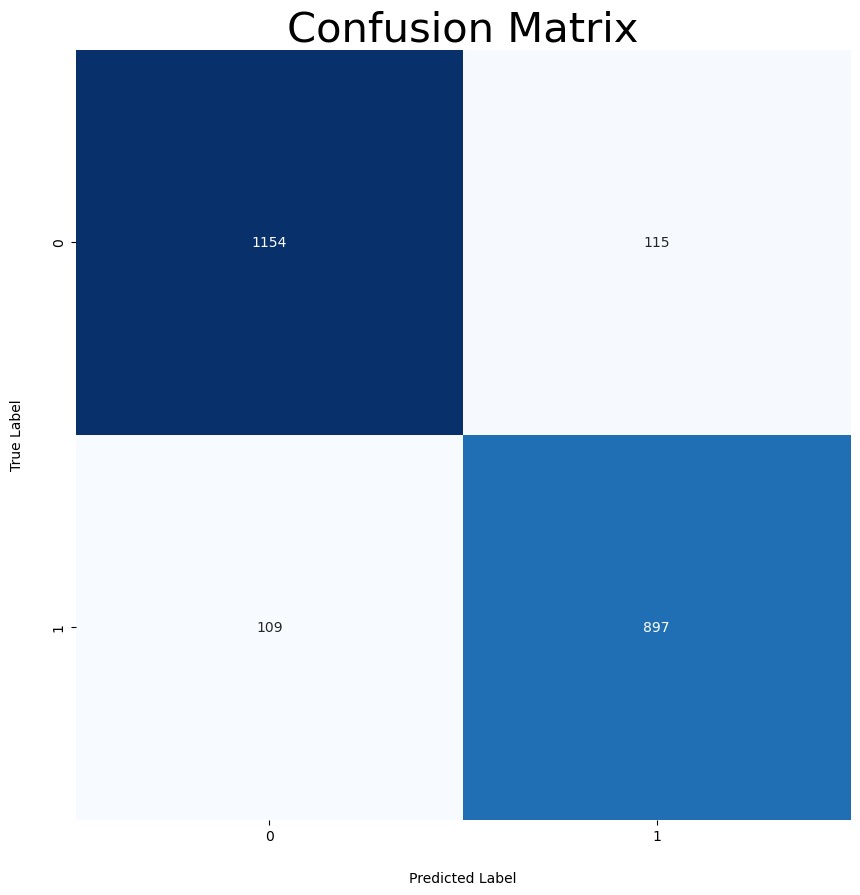

In [82]:
cnn_model_report = generate_confusion_matrix(
    model=third,
    dataset=valid_dataset,
)

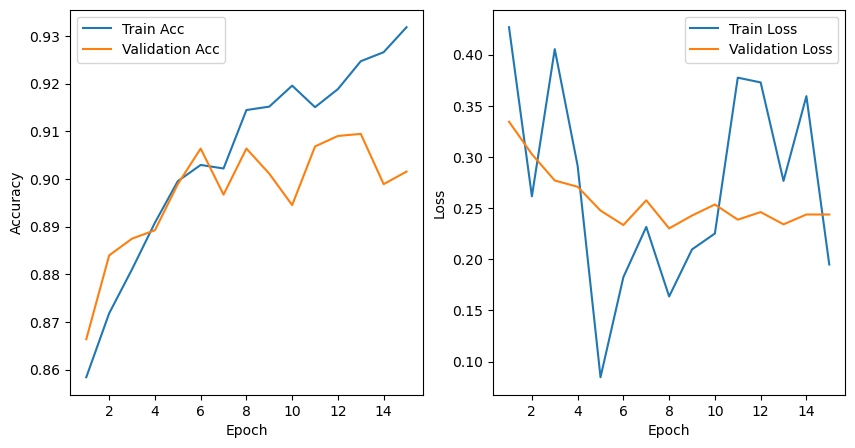

In [83]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

با توجه به ماتریس به دست آمده میبینیم که فالس نگتیو ها کم تر شده که در شرایط مسئله بهتر از فالس پازتیو کمتر است با اینکه دقت ثابت است ولی متریک های دیگر مثل ریکال و پرسیژن بهتر است

In [84]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.901
F1:        0.900
Precision: 0.900
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1269
           1       0.89      0.89      0.89      1006

    accuracy                           0.90      2275
   macro avg       0.90      0.90      0.90      2275
weighted avg       0.90      0.90      0.90      2275

